# Edit based distance to [1] v85 StableID_key sequence & [2] canonical uniprot sequences
### Hamming + normalized col
### Levenshtein + normalized col 
---

## Pairwise sequence alignment is the process of comparing only two strings
* edit distance hard to compute for longer strings
* hamming needs same length, but i like that it looks at positions, since one insertions is one change but that could through off positions by alot

* hamming and levenshtein are both edit based, but hamming penalizes on positional differences whereas levenshtein does not

### Levenshtein distance = 
- In information theory, linguistics and computer science, the Levenshtein distance is a string metric for measuring the difference between two sequences. Informally, the Levenshtein distance between two words is the minimum number of single-character edits (insertions, deletions or substitutions) required to change one word into the other. It is named after the Soviet mathematician Vladimir Levenshtein, who considered this distance in 1965.[1]


### Damerau–Levenshtein distance = 
- differs from the classical Levenshtein distance by including transpositions among its allowable operations in addition to the three classical single-character edit operations (insertions, deletions and substitutions).[4][2]

##### From the elementary costs, we set
> δE = min{cost of σ : σ ∈ Sx,y}
    
    where Sx,y is the set of sequences of elementary edit operationsthat transform x into y, and the cost of an element σ ∈ Sx,y is the sum of the costs of the edit operations of the sequence σ. The function δE is then a distance on Σ ∗, and it is called the edit distance (Damerau-Levenshtein distance).

---

### Relationship with other edit distance metrics
There are other popular measures of edit distance, which are calculated using a different set of allowable edit operations. For instance,
1. the Levenshtein distance allows deletion, insertion and substitution;
2. the Damerau–Levenshtein distance allows insertion, deletion, substitution, and the transposition of two adjacent characters;
3. the longest common subsequence (LCS) distance allows only insertion and deletion, not substitution;
4. the Hamming distance allows only substitution, hence, it only applies to strings of the same length.
> Edit distance is usually defined as a parameterizable metric calculated with a specific set of allowed edit operations, and each operation is assigned a cost (possibly infinite). This is further generalized by DNA sequence alignment algorithms such as the Smith–Waterman algorithm, which make an operation's cost depend on where it is applied.

**Levenshtein counts the number of edits (insertions, deletions, or substitutions) needed to convert one string to the other. Damerau-Levenshtein is a modified version that also considers transpositions as single edits. Although the output is the integer number of edits, this can be normalized to give a similarity value by the formula**

> 1 - (edit distance / length of the larger of the two strings)

    The Jaro algorithm is a measure of characters in common, being no more than half the length of the longer string in distance, with consideration for transpositions. Winkler modified this algorithm to support the idea that differences near the start of the string are more significant than differences near the end of the string. Jaro and Jaro-Winkler are suited for comparing smaller strings like words and names.

Deciding which to use is not just a matter of performance. It's important to pick a method that is suited to the nature of the strings you are comparing. In general though, both of the algorithms you mentioned can be expensive, because each string must be compared to every other string, and with millions of strings in your data set, that is a tremendous number of comparisons. That is much more expensive than something like computing a phonetic encoding for each string, and then simply grouping strings sharing identical encodings.

In [4]:
# packages

from statistics import stdev, mean
import os
import sys
import numpy as np
import pandas as pd
from ast import literal_eval # for mismap_score func
import difflib
import jellyfish
import textdistance
import matplotlib.pyplot as plt

from IPython.display import display, HTML
pd.set_option('display.max_columns', None)
pd.options.display.max_seq_items = 2000
display(HTML("<style>.container {width:90% !important;}</style>"))
sys.path.append("/Users/mariapalafox/Desktop/Toolbox")
from all_funx import *

# i want to use both the hamming distance and the levenshtein distance
- both edit distance algorithms, hamming considers positional difference, therefore only allows substitutions
- levenshtein allows substitutions, deletion, and insertion of 1 AA
- if insertion is at last position in string
    > example MARIA + P, then both are 1
    
- if insertion is at first position in string
    > example M + MARIA then leven is 1 still but hamming is 5, normalized hamming is 5/6

In [2]:
sys.path.append("/Users/mariapalafox/Desktop/Toolbox/")
from all_funx import *
from maplib import *

In [3]:
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.options.display.max_seq_items = 2000

In [16]:
m = "MARIA"
m2 = "AAR"
m3 = "MARIAA"
m4 = "MMARIA"
print(jellyfish.hamming_distance(m, m4))
print(textdistance.hamming.normalized_distance(m, m4))
print(textdistance.hamming.normalized_distance(m4, m))
# 5/6 = 0.8333333333333334 so hamming normalized takes the longest len as denom and num is # mismatched positions
print(textdistance.levenshtein(m4, m))

5
0.8333333333333334
0.8333333333333334
1


In [17]:
def identicalSequences(dfEnsp, ref_dic, newcolresult, hamming, hammingNorm, levenshtein, levenshteinNorm):
    res = []
    #ham = []
    hamnorm = []
    #lev = []
    levnorm = []
    serSeq = dfEnsp['proSequence'].copy()
    serID = dfEnsp['stableID_key'].copy()
    for inx, val in serSeq.items():
        pep = str(val)
        p = pep.strip()
        idd = str(serID[inx])
        # check pep to dict pep sequence
        mypep = ref_dic[idd]
        str(mypep)
        # identical
        if mypep == p:
            res.append('True')
            #ham.append(textdistance.hamming(mypep, p))
            # normalized hamming = # mismatched positions/ len of longer sequence
            hamnorm.append(textdistance.hamming.normalized_distance(mypep, p))
            # levenshtein score is edit based but not not penalized position, insertion at pos 1 is jsut 1 diff
            #lev.append(textdistance.levenshtein(mypep,p))
            levnorm.append(textdistance.levenshtein.normalized_distance(mypep, p))
        # not identical to canonical
        if mypep != p: 
            res.append('False')
            # calculates hamming distance, penalizes positional differences, edit based distance
            #ham.append(textdistance.hamming(mypep, p))
            # normalized hamming = # mismatched positions/ len of longer sequence
            hamnorm.append(textdistance.hamming.normalized_distance(mypep, p))
            # levenshtein score is edit based but not not penalized position, insertion at pos 1 is jsut 1 diff
            #lev.append(textdistance.levenshtein(mypep,p))
            levnorm.append(textdistance.levenshtein.normalized_distance(mypep, p))
            
    # add new column
    dfEnsp.loc[:,newcolresult] = res
    #dfEnsp.loc[:,hamming] = ham
    dfEnsp.loc[:,hammingNorm] = hamnorm
    #dfEnsp.loc[:,levenshtein] = lev
    dfEnsp.loc[:,levenshteinNorm] = levnorm
    return dfEnsp

---
---

In [7]:
os.chdir("/Users/mariapalafox/Box Sync/CODE_DATA/dir_MAPpaper/TSV_UNIPROT_xref/DISTANCE_HEAT")





In [20]:
# creating dictionary of ENSTv85 sequences
refdf = pd.read_csv("LASER_dynamic_slope_leven_hamming_shared3887_44305rows.csv")
refdf.head(1)

,ENSPv,ENSP,ENSTv,ENST,ENSGv,ENSG,Length,proSequence,stableID_key,ID,pro_ver,tx_ver,gen_ver,identical_2UKBseq,Length_UKB,len_ensp_minus_ukb,hamming_distance,hamming_normalized_dist,levenshtein_distance,levenshtein_normalized_dist,key_8861,entryName,labeled_pos_count,pos_dict,count_C_targets,count_K_targets,found_count,found_count_C,found_count_K,missed_count,missed_count_C,missed_count_K,correct_frac,missed_frac,release,HGNC_gene,dynamic_slope_LEVENnorm,dynamic_slope_HAMMINGnorm
0,ENSP00000000233.5,ENSP00000000233,ENST00000000233.5,ENST00000000233,ENSG00000004059.6,ENSG00000004059,180,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,ENSG00000004059_ENST00000000233_ENSP00000000233,P84085,5,5,6,True,180,0,0.0,0.0,0.0,0.0,True,ARF5_HUMAN,4,"{38: 'K', 62: 'C', 159: 'C', 179: 'K'}",2,2,4,2,2,0,0,0,1.0,0.0,85,ARF5,1,1


# DISTANCE to v85 sequences: adding distance values to csv of each release including TRUE / FALSE identity scores 
- all distance scores in relationship to canonical ukb sequence in which the ENSP ID is linked to

In [21]:
# isolate v85
ref85df = refdf[refdf['release'] == 85].copy()
print(ref85df.shape)

# creating dictionary from ID and Sequence columns
ref_dic = dict(zip(ref85df.stableID_key, ref85df.proSequence))

ref_dic["ENSG00000004059_ENST00000000233_ENSP00000000233"]

refdf = refdf[['ENSPv', 'ENSP', 'ENSTv', 'ENST', 'ENSGv', 'ENSG', 'Length',
       'proSequence', 'stableID_key', 'ID', 'pro_ver', 'tx_ver', 'gen_ver',
       'identical_2UKBseq', 'Length_UKB', 'len_ensp_minus_ukb',
       'key_8861', 'entryName','labeled_pos_count', 'pos_dict', 'missed_count',
       'missed_count_C', 'missed_count_K', 'missed_frac',
       'release', 'HGNC_gene']].copy()

# isolate other releases
v92 = refdf[refdf['release'] == 92].copy()
v94 = refdf[refdf['release'] == 94].copy()
v96 = refdf[refdf['release'] == 96].copy()
v97 = refdf[refdf['release'] == 97].copy()
print(v92.shape)

(8861, 38)
(8861, 26)


In [22]:
v92 = identicalSequences(v92, ref_dic, "matched_v85seq", "hamming_distance", "hamming_normalized_dist", "levenshtein_distance", "levenshtein_normalized_dist")
checkColumnValues(v92, 'matched_v85seq')

v94 = identicalSequences(v94, ref_dic, "matched_v85seq", "hamming_distance", "hamming_normalized_dist", "levenshtein_distance", "levenshtein_normalized_dist")
checkColumnValues(v94, 'matched_v85seq')

v96 = identicalSequences(v96, ref_dic, "matched_v85seq", "hamming_distance", "hamming_normalized_dist", "levenshtein_distance", "levenshtein_normalized_dist")
checkColumnValues(v96, 'matched_v85seq')

v97 = identicalSequences(v97, ref_dic, "matched_v85seq", "hamming_distance", "hamming_normalized_dist", "levenshtein_distance", "levenshtein_normalized_dist")
checkColumnValues(v97, 'matched_v85seq')

  matched_v85seq  Count
0           True   8729
1          False    132
  matched_v85seq  Count
0           True   8728
1          False    133
  matched_v85seq  Count
0           True   8710
1          False    151
  matched_v85seq  Count
0           True   8699
1          False    162


In [23]:
# drop rows with identitical sequences to v85
dfs = [v92,v94,v96,v97]
for i in dfs: 
    i.drop(i[i['matched_v85seq'] == "True"].index, inplace=True)
    i.reset_index(inplace=True, drop=True)

## How many unique uniprot IDs in v92-v97 file with scored distance from v85 stableID_key matched sequence?


In [24]:
dfs = [v92,v94,v96,v97]
for i in dfs: 
    uniqueCount(i, 'ID')

len of col:  132
len of col set:  98

len of col:  133
len of col set:  99

len of col:  151
len of col set:  114

len of col:  162
len of col set:  121



In [25]:
# unique set of IDs in each release
uni92 = set(v92['stableID_key'].tolist())
uni94 = set(v94['stableID_key'].tolist())
uni96 = set(v96['stableID_key'].tolist())
uni97 = set(v97['stableID_key'].tolist())

# IDs in all releases
shared = uni92 & uni94 & uni96 & uni97
print("set of shared IDs: ")
print(len(set(shared)))
shared = list(shared)
# set of shared IDs: 132

# drops rows where ID does not match list IDs 'Lever'
def dropNotLabeled(df, Lever):
    df['shared132'] = np.where(df['stableID_key'].isin(Lever),"True","False")
    df2 = df[df['shared132']=="True"].copy()
    print("sorting ID column and resetting index: ")
    df2.sort_values(by=['stableID_key'],inplace=True)
    df2.reset_index(drop=True, inplace=True)
    print("shape final cleaned df: ", df2.shape)
    return df2

shared92 = dropNotLabeled(v92,shared)
shared94 = dropNotLabeled(v94,shared)
shared96 = dropNotLabeled(v96,shared)
shared97 = dropNotLabeled(v97,shared)

uniqueCount(shared92, 'ID')
uniqueCount(shared94, 'ID')
uniqueCount(shared96, 'ID')
uniqueCount(shared97, 'ID')

set of shared IDs: 
132
sorting ID column and resetting index: 
shape final cleaned df:  (132, 30)
sorting ID column and resetting index: 
shape final cleaned df:  (132, 30)
sorting ID column and resetting index: 
shape final cleaned df:  (132, 30)
sorting ID column and resetting index: 
shape final cleaned df:  (132, 30)
len of col:  132
len of col set:  98

len of col:  132
len of col set:  98

len of col:  132
len of col set:  98

len of col:  132
len of col set:  98



## result is 98 unique uniprot IDs in shared set of v92-v97 stableIDs not identical to v85 sequence

In [26]:
print(set(shared92.HGNC_gene.tolist()))

{'PXK', 'RPS24', 'RPL10', 'GCN1', 'DDX24', 'HECTD1', 'CAPZB', 'PRRC2C', 'SYNM', 'CNOT3', 'DIABLO', 'DOCK8', 'XRCC1', 'UTP4', 'GRIPAP1', 'GNAI2', 'CSNK2A1', 'FHL2', 'NUDT1', 'TRERF1', 'APOB', 'SLC4A8', 'CCDC50', 'BRD2', 'YAP1', 'SCRIB', 'AIP', 'LENG1', 'PAX2', 'SHMT1', 'DHX30', 'SMAD5', 'MAPK8', 'HDLBP', 'AP1B1', 'PRKDC', 'SMYD3', 'PARG', 'CASK', 'AKT2', 'DOCK7', 'NRF1', 'PPP2R2D', 'MBD3', 'USO1', 'ATG2A', 'COMT', 'RAD50', 'MYO9A', 'SPTB', 'ANXA11', 'GSN', 'LIMS1', 'CHTOP', 'CUX1', 'WNK1', 'RPL11', 'AGK', 'NUMB', 'MPST', 'AKAP8L', 'KTN1', 'GART', 'CTNND1', 'RAPGEF6', 'PRKD2', 'PNPO', 'BIRC6', 'PRORP', 'SEPHS1', 'ERC1', 'SURF2', 'CHEK1', 'GRB10', 'OTUD6B', 'INPP5D', 'ATM', 'RNF40', 'ATXN2', 'PDLIM2', 'NCF1', 'FAM135A', 'SAMHD1', 'SSBP1', 'TIMM50', 'EP400', 'SHTN1', 'HAT1', 'SUN3', 'HNRNPDL', 'CAST', 'ECT2', 'OPTN', 'BAG6', 'PCK2', 'TCOF1', 'VIPAS39', 'SVIL'}


In [28]:
dfs = [shared92,shared94,shared96,shared97]
for i in dfs: 
    i.sort_values(['levenshtein_normalized_dist', 'hamming_normalized_dist'], inplace=True)
    i.drop_duplicates(subset='ID', keep='last', inplace=True)
    print(i.shape)
    print()

(98, 30)

(98, 30)

(98, 30)

(98, 30)



In [29]:
merger98 = pd.concat([shared92, shared94, shared96, shared97])
merger98

,ENSPv,ENSP,ENSTv,ENST,ENSGv,ENSG,Length,proSequence,stableID_key,ID,pro_ver,tx_ver,gen_ver,identical_2UKBseq,Length_UKB,len_ensp_minus_ukb,key_8861,entryName,labeled_pos_count,pos_dict,missed_count,missed_count_C,missed_count_K,missed_frac,release,HGNC_gene,matched_v85seq,hamming_normalized_dist,levenshtein_normalized_dist,shared132
59,ENSP00000393596.2,ENSP00000393596,ENST00000421745.6,ENST00000421745,ENSG00000115760.13,ENSG00000115760,4857,MVTGGGAAPPGTVTEPLPSVIVLSAGRKMAAAAAAASGPGCSSAAG...,ENSG00000115760_ENST00000421745_ENSP00000393596,Q9NR09,2,6,13,False,4857,0,True,BIRC6_HUMAN,3,"{543: 'C', 1517: 'C', 1547: 'C'}",0,0,0,0.00,92,BIRC6,False,0.000206,0.000206,True
15,ENSP00000233242.1,ENSP00000233242,ENST00000233242.5,ENST00000233242,ENSG00000084674.14,ENSG00000084674,4563,MDPPRPALLALLALPALLLLLLAGARAEEEMLENVSLVCPKDATRF...,ENSG00000084674_ENST00000233242_ENSP00000233242,P04114,1,5,14,False,4563,0,True,APOB_HUMAN,1,{2966: 'K'},0,0,0,0.00,92,APOB,False,0.000219,0.000219,True
120,ENSP00000313420.3,ENSP00000313420,ENST00000314191.6,ENST00000314191,ENSG00000253729.7,ENSG00000253729,4128,MAGSGAGVRCSLLRLQETLSAADRCGAALAGHQLIRGLGQECVLSS...,ENSG00000253729_ENST00000314191_ENSP00000313420,P78527,3,6,7,True,4128,0,True,PRKDC_HUMAN,21,"{25: 'C', 90: 'C', 223: 'C', 232: 'C', 373: 'C...",0,0,0,0.00,92,PRKDC,False,0.646560,0.000242,True
108,ENSP00000374213.3,ENSP00000374213,ENST00000389562.6,ENST00000389562,ENSG00000183495.13,ENSG00000183495,3123,MHHGTGPQNVQHQLQRSRACPGSEGEEQPAHPNPPPSPAAPFAPSA...,ENSG00000183495_ENST00000389562_ENSP00000374213,Q96L91,3,6,13,False,3159,-36,True,EP400_HUMAN,2,"{162: 'C', 694: 'C'}",1,1,0,0.50,92,EP400,False,0.769452,0.000320,True
87,ENSP00000388058.2,ENSP00000388058,ENST00000452508.6,ENST00000452508,ENSG00000149311.18,ENSG00000149311,3056,MSLVLNDLLICCRQLEHDRATERKKEVEKFKRLIRDPETIKHLDRH...,ENSG00000149311_ENST00000452508_ENSP00000388058,Q13315,2,6,18,True,3056,0,True,ATM_HUMAN,4,"{2021: 'C', 2607: 'C', 2770: 'C', 2991: 'C'}",0,0,0,0.00,92,ATM,False,0.000327,0.000327,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,ENSP00000324697.9,ENSP00000324697,ENST00000321130.14,ENST00000321130,ENSG00000100890.15,ENSG00000100890,211,MRDVIDGGDQYRKTTPQELKRFENFIKSRPPFDVVIDGLNVAKMFP...,ENSG00000100890_ENST00000321130_ENSP00000324697,O15091,9,14,15,False,583,-372,True,MRPP3_HUMAN,1,{367: 'C'},1,1,0,1.00,97,PRORP,False,0.978836,0.627866,True
57,ENSP00000350846.5,ENSP00000350846,ENST00000358129.8,ENST00000358129,ENSG00000115641.19,ENSG00000115641,151,MTERFDCHHCNESLFGKKYILREESPYCVVCFETLFANTCEECGKP...,ENSG00000115641_ENST00000358129_ENSP00000350846,Q14192,5,8,19,False,279,-128,True,FHL2_HUMAN,9,"{10: 'C', 28: 'C', 129: 'C', 132: 'C', 144: 'K...",6,4,2,0.67,97,FHL2,False,0.784946,0.648746,True
125,ENSP00000461700.2,ENSP00000461700,ENST00000575273.5,ENST00000575273,ENSG00000262473.5,ENSG00000262473,308,XAQTWRIPRVFSWLQQEGHLSEEEMARTFNCGVGAVLVVSKEQTEQ...,ENSG00000262473_ENST00000575273_ENSP00000461700,P22102,2,5,5,False,1010,-702,True,PUR2_HUMAN,20,"{28: 'K', 41: 'C', 62: 'C', 93: 'C', 134: 'C',...",20,10,10,1.00,97,GART,False,0.983168,0.696040,True
4,ENSP00000399162.2,ENSP00000399162,ENST00000424560.2,ENST00000424560,ENSG00000066933.16,ENSG00000066933,729,MNINDGGRRRFEDNEHTLRIYPGAISEGTIYCPIPARKNSTAAEVI...,ENSG00000066933_ENST00000424560_ENSP00000399162,B2RTY4,2,2,16,False,2548,-1819,True,MYO9A_HUMAN,1,{2032: 'C'},1,1,0,1.00,97,MYO9A,False,0.722031,0.721649,True


In [31]:
merger98[merger98['HGNC_gene'] == 'CHEK1']

,ENSPv,ENSP,ENSTv,ENST,ENSGv,ENSG,Length,proSequence,stableID_key,ID,pro_ver,tx_ver,gen_ver,identical_2UKBseq,Length_UKB,len_ensp_minus_ukb,key_8861,entryName,labeled_pos_count,pos_dict,missed_count,missed_count_C,missed_count_K,missed_frac,release,HGNC_gene,matched_v85seq,hamming_normalized_dist,levenshtein_normalized_dist,shared132
88,ENSP00000442317.2,ENSP00000442317,ENST00000544373.5,ENST00000544373,ENSG00000149554.12,ENSG00000149554,382,MEKPDIGMPEPDAQRFFHQLMAGVVYLHGIGITHRDIKPENLLLDE...,ENSG00000149554_ENST00000544373_ENSP00000442317,O14757,2,5,12,False,476,-94,True,CHK1_HUMAN,1,{292: 'K'},1,0,1,1.0,92,CHEK1,False,0.957014,0.289593,True
88,ENSP00000442317.2,ENSP00000442317,ENST00000544373.5,ENST00000544373,ENSG00000149554.12,ENSG00000149554,382,MEKPDIGMPEPDAQRFFHQLMAGVVYLHGIGITHRDIKPENLLLDE...,ENSG00000149554_ENST00000544373_ENSP00000442317,O14757,2,5,12,False,476,-94,True,CHK1_HUMAN,1,{292: 'K'},1,0,1,1.0,94,CHEK1,False,0.957014,0.289593,True
88,ENSP00000442317.2,ENSP00000442317,ENST00000544373.5,ENST00000544373,ENSG00000149554.12,ENSG00000149554,382,MEKPDIGMPEPDAQRFFHQLMAGVVYLHGIGITHRDIKPENLLLDE...,ENSG00000149554_ENST00000544373_ENSP00000442317,O14757,2,5,12,False,476,-94,True,CHK1_HUMAN,1,{292: 'K'},1,0,1,1.0,96,CHEK1,False,0.957014,0.289593,True
88,ENSP00000442317.2,ENSP00000442317,ENST00000544373.5,ENST00000544373,ENSG00000149554.13,ENSG00000149554,382,MEKPDIGMPEPDAQRFFHQLMAGVVYLHGIGITHRDIKPENLLLDE...,ENSG00000149554_ENST00000544373_ENSP00000442317,O14757,2,5,13,False,476,-94,True,CHK1_HUMAN,1,{292: 'K'},1,0,1,1.0,97,CHEK1,False,0.957014,0.289593,True


In [30]:
gene_stable = merger98.groupby('HGNC_gene')['levenshtein_normalized_dist'].apply(list)
gene_stable = pd.DataFrame(gene_stable)
gene_stable
gene_stable.to_csv("v85_VERSUS_otherRelease98genes_groupby_HGNC.csv")

# results of comparing v85 to other releases (shared 8861 stable ID keys)
- 98 shared and all unique uniprot id rows for each release saved
- problem with 98 is all numbers are identical....measuring distance from ensembl sequences...internal to ensembl question

## comparing to uniprot ALTERNATIVE
- pro is complex system
- overlap between dynamic slope and bad score 

# ALTERNATE route: compare stableID keys to linked UniProt canonical sequences for distance measure 
- using 3887 file

In [32]:
# creating dictionary of ENSTv85 sequences
refdf = pd.read_csv("LASER_dynamic_slope_leven_hamming_shared3887_44305rows.csv")
refdf.head(1)

,ENSPv,ENSP,ENSTv,ENST,ENSGv,ENSG,Length,proSequence,stableID_key,ID,pro_ver,tx_ver,gen_ver,identical_2UKBseq,Length_UKB,len_ensp_minus_ukb,hamming_distance,hamming_normalized_dist,levenshtein_distance,levenshtein_normalized_dist,key_8861,entryName,labeled_pos_count,pos_dict,count_C_targets,count_K_targets,found_count,found_count_C,found_count_K,missed_count,missed_count_C,missed_count_K,correct_frac,missed_frac,release,HGNC_gene,dynamic_slope_LEVENnorm,dynamic_slope_HAMMINGnorm
0,ENSP00000000233.5,ENSP00000000233,ENST00000000233.5,ENST00000000233,ENSG00000004059.6,ENSG00000004059,180,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,ENSG00000004059_ENST00000000233_ENSP00000000233,P84085,5,5,6,True,180,0,0.0,0.0,0.0,0.0,True,ARF5_HUMAN,4,"{38: 'K', 62: 'C', 159: 'C', 179: 'K'}",2,2,4,2,2,0,0,0,1.0,0.0,85,ARF5,1,1


In [34]:
# TITIN GENE does not have distance scores because proSequence was too large to calculate
refdf = refdf[refdf['HGNC_gene'] != 'TTN']

In [35]:
describeMe(refdf)

(44280, 38)
Index(['ENSPv', 'ENSP', 'ENSTv', 'ENST', 'ENSGv', 'ENSG', 'Length',
       'proSequence', 'stableID_key', 'ID', 'pro_ver', 'tx_ver', 'gen_ver',
       'identical_2UKBseq', 'Length_UKB', 'len_ensp_minus_ukb',
       'hamming_distance', 'hamming_normalized_dist', 'levenshtein_distance',
       'levenshtein_normalized_dist', 'key_8861', 'entryName',
       'labeled_pos_count', 'pos_dict', 'count_C_targets', 'count_K_targets',
       'found_count', 'found_count_C', 'found_count_K', 'missed_count',
       'missed_count_C', 'missed_count_K', 'correct_frac', 'missed_frac',
       'release', 'HGNC_gene', 'dynamic_slope_LEVENnorm',
       'dynamic_slope_HAMMINGnorm'],
      dtype='object')
ENSPv                           0
ENSP                            0
ENSTv                           0
ENST                            0
ENSGv                           0
ENSG                            0
Length                          0
proSequence                     0
stableID_key              

In [38]:
# only 3 decimal place column formatting
refdf = refdf.round({"hamming_normalized_dist":2, "levenshtein_normalized_dist":2})

In [39]:
checkColumnValues(refdf, 'dynamic_slope_LEVENnorm')
print()
print("hamming")
checkColumnValues(refdf, 'dynamic_slope_HAMMINGnorm')

   dynamic_slope_LEVENnorm  Count
0                        1  43470
1                        2    810

hamming
   dynamic_slope_HAMMINGnorm  Count
0                          1  43530
1                          2    750


```python
# all5 = refdf['stableID_key'].value_counts()
# all5.to_csv("all5.csv")
```

#### QC pass: all stableID_keys occur in refdf 5 times

In [87]:
# filter for rows with dynamic 2 score for both hamming and leven normalized

dyn = refdf[(refdf['dynamic_slope_LEVENnorm'] == 2) & (refdf['dynamic_slope_HAMMINGnorm'] == 2)]
dyn1 = refdf[(refdf['dynamic_slope_LEVENnorm'] == 1) & (refdf['dynamic_slope_HAMMINGnorm'] == 1)]

checkColumnValues(dyn, 'release')  
checkColumnValues(dyn1, 'release')         



uniqueCount(dyn, 'HGNC_gene')
uniqueCount(dyn1, 'HGNC_gene')

#dyn.sort_values(by=['stableID_key','release'], ascending=False, inplace=True)



   release  Count
0       97    150
1       96    150
2       94    150
3       92    150
4       85    150
   release  Count
0       94   8694
1       92   8694
2       85   8694
3       97   8694
4       96   8694
len of col:  750
len of col set:  118

len of col:  43470
len of col set:  3839



In [88]:
dyn1.head(3)

,ENSPv,ENSP,ENSTv,ENST,ENSGv,ENSG,Length,proSequence,stableID_key,ID,pro_ver,tx_ver,gen_ver,identical_2UKBseq,Length_UKB,len_ensp_minus_ukb,hamming_distance,hamming_normalized_dist,levenshtein_distance,levenshtein_normalized_dist,key_8861,entryName,labeled_pos_count,pos_dict,count_C_targets,count_K_targets,found_count,found_count_C,found_count_K,missed_count,missed_count_C,missed_count_K,correct_frac,missed_frac,release,HGNC_gene,dynamic_slope_LEVENnorm,dynamic_slope_HAMMINGnorm
0,ENSP00000000233.5,ENSP00000000233,ENST00000000233.5,ENST00000000233,ENSG00000004059.6,ENSG00000004059,180,MGLTVSALFSRIFGKKQMRILMVGLDAAGKTTILYKLKLGEIVTTI...,ENSG00000004059_ENST00000000233_ENSP00000000233,P84085,5,5,6,True,180,0,0.0,0.0,0.0,0.0,True,ARF5_HUMAN,4,"{38: 'K', 62: 'C', 159: 'C', 179: 'K'}",2,2,4,2,2,0,0,0,1.0,0.0,85,ARF5,1,1
1,ENSP00000001008.4,ENSP00000001008,ENST00000001008.4,ENST00000001008,ENSG00000004478.5,ENSG00000004478,459,MTAEEMKATESGAQSAPLPMEGVDISPKQDEGVLKVIKREGTGTEM...,ENSG00000004478_ENST00000001008_ENSP00000001008,Q02790,4,4,5,True,459,0,0.0,0.0,0.0,0.0,True,FKBP4_HUMAN,16,"{28: 'K', 103: 'C', 222: 'K', 274: 'K', 282: '...",3,13,16,3,13,0,0,0,1.0,0.0,85,FKBP4,1,1
2,ENSP00000003302.4,ENSP00000003302,ENST00000003302.4,ENST00000003302,ENSG00000048028.7,ENSG00000048028,1077,MTAELQQDDAAGAADGHGSSCQMLLNQLREITGIQDPSFLHEALKA...,ENSG00000048028_ENST00000003302_ENSP00000003302,Q96RU2,4,4,7,True,1077,0,0.0,0.0,0.0,0.0,True,UBP28_HUMAN,3,"{45: 'K', 171: 'C', 733: 'C'}",2,1,3,2,1,0,0,0,1.0,0.0,85,USP28,1,1


## Distance to uniprot from all 5 ensembl releases, 
1. filtered for only rows with 'dynamic_slope_HammingORleven_normalized' score of 2 (equivalent to 2 unique distance scores between sequences scores from stableID_key matched sequences)
2. confirmed all stableID_keys had 5 sequences linked
3. calculating RANGE, AVERAGE, and LENGTH of groupby() stableIDkey file, irrespective of release order



In [67]:
# FROM MAPLIB.py
# functions that work on list
def setme(s):
    ls = list(s)
    finalset = set(ls)
    return finalset

def avgme(s):
    return mean(s)

def rangefinder(s):
    maxx = max(s)
    minn = min(s)
    diff = maxx - minn
    return diff

def group_scores(df, colname):
    # hamming_normalized_dist
    # levenshtein_normalized_dist
    lsdf = df.groupby('stableID_key')[colname].apply(list)
    lsdf = pd.DataFrame(lsdf)
        # concat all frames together
        #set_columns = pd.concat([lsdf, avgdf], axis=1)
        # problem with duplicated colnames from concat files
    lsdf['avg_distscr'] = lsdf[colname].apply(avgme)
    lsdf['range_distscr'] = lsdf[colname].apply(rangefinder)
    lsdf['max_dist_scr'] = lsdf[colname].apply(lambda x: max(x))
    print("group df shape: ", lsdf.shape)
    print(lsdf.head(1))
    return lsdf

In [68]:
# creating groupby df's for each score 

hamming_group = group_scores(dyn, 'hamming_normalized_dist')
hamming_group.columns = ['hamming_normalized_dist', 'HAM_avg_distscr', 'HAM_range_distscr',
       'HAM_max_dist_scr']


leven_group = group_scores(dyn, 'levenshtein_normalized_dist')
leven_group.columns = ['levenshtein_normalized_dist', 'LEVEN_avg_distscr', 'LEVEN_range_distscr',
       'LEVEN_max_dist_scr']

# combining 2 score df's
mergescores = pd.concat([hamming_group, leven_group], axis=1)
mergescores

group df shape:  (150, 4)
                                                   hamming_normalized_dist  \
stableID_key                                                                 
ENSG00000011243_ENST00000397410_ENSP00000380557  [0.0, 0.0, 0.0, 0.0, 0.0]   

                                                 avg_distscr  range_distscr  \
stableID_key                                                                  
ENSG00000011243_ENST00000397410_ENSP00000380557          0.0            0.0   

                                                 max_dist_scr  
stableID_key                                                   
ENSG00000011243_ENST00000397410_ENSP00000380557           0.0  


In [89]:
# creating groupby df's for each score DYNAMIC 1 CHECK

hamming_group1 = group_scores(dyn1, 'hamming_normalized_dist')
hamming_group1.columns = ['hamming_normalized_dist', 'HAM_avg_distscr', 'HAM_range_distscr',
       'HAM_max_dist_scr']


leven_group1 = group_scores(dyn1, 'levenshtein_normalized_dist')
leven_group1.columns = ['levenshtein_normalized_dist', 'LEVEN_avg_distscr', 'LEVEN_range_distscr',
       'LEVEN_max_dist_scr']

# combining 2 score df's
mergescores1 = pd.concat([hamming_group1, leven_group1], axis=1)

group df shape:  (8694, 4)
                                                        hamming_normalized_dist  \
stableID_key                                                                      
ENSG00000001497_ENST00000374804_ENSP00000363937  [0.85, 0.85, 0.85, 0.85, 0.85]   

                                                 avg_distscr  range_distscr  \
stableID_key                                                                  
ENSG00000001497_ENST00000374804_ENSP00000363937         0.85            0.0   

                                                 max_dist_scr  
stableID_key                                                   
ENSG00000001497_ENST00000374804_ENSP00000363937          0.85  
group df shape:  (8694, 4)
                                                    levenshtein_normalized_dist  \
stableID_key                                                                      
ENSG00000001497_ENST00000374804_ENSP00000363937  [0.08, 0.08, 0.08, 0.08, 0.08]   

                

In [90]:

describeMe(mergescores)
describeMe(mergescores1)




(150, 11)
Index(['stableID_key', 'hamming_normalized_dist', 'HAM_avg_distscr',
       'HAM_range_distscr', 'HAM_max_dist_scr', 'levenshtein_normalized_dist',
       'LEVEN_avg_distscr', 'LEVEN_range_distscr', 'LEVEN_max_dist_scr',
       'HGNC_gene', 'ID'],
      dtype='object')
stableID_key                   0
hamming_normalized_dist        0
HAM_avg_distscr                0
HAM_range_distscr              0
HAM_max_dist_scr               0
levenshtein_normalized_dist    0
LEVEN_avg_distscr              0
LEVEN_range_distscr            0
LEVEN_max_dist_scr             0
HGNC_gene                      0
ID                             0
dtype: int64
(8694, 8)
Index(['hamming_normalized_dist', 'HAM_avg_distscr', 'HAM_range_distscr',
       'HAM_max_dist_scr', 'levenshtein_normalized_dist', 'LEVEN_avg_distscr',
       'LEVEN_range_distscr', 'LEVEN_max_dist_scr'],
      dtype='object')
hamming_normalized_dist        0
HAM_avg_distscr                0
HAM_range_distscr              0
HAM_max

In [91]:
#mergescores.reset_index(inplace=True)
mergescores1.reset_index(inplace=True)
mergescores

,index,stableID_key,hamming_normalized_dist,HAM_avg_distscr,HAM_range_distscr,HAM_max_dist_scr,levenshtein_normalized_dist,LEVEN_avg_distscr,LEVEN_range_distscr,LEVEN_max_dist_scr,HGNC_gene,ID
0,0,ENSG00000011243_ENST00000397410_ENSP00000380557,"[0.0, 0.0, 0.0, 0.0, 0.0]",0.000,0.00,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0]",0.000,0.00,0.00,AKAP8L,Q9ULX6
1,1,ENSG00000011376_ENST00000265537_ENSP00000265537,"[0.0, 0.0, 0.0, 0.4, 0.4]",0.160,0.40,0.40,"[0.0, 0.0, 0.0, 0.37, 0.37]",0.148,0.37,0.37,LARS2,Q15031
2,2,ENSG00000050438_ENST00000358657_ENSP00000351483,"[0.94, 0.94, 0.94, 0.94, 0.94]",0.940,0.00,0.94,"[0.09, 0.05, 0.05, 0.05, 0.05]",0.058,0.04,0.09,SLC4A8,Q2Y0W8
3,3,ENSG00000060237_ENST00000340908_ENSP00000341292,"[0.94, 0.68, 0.68, 0.68, 0.68]",0.732,0.26,0.94,"[0.17, 0.16, 0.16, 0.16, 0.16]",0.162,0.01,0.17,WNK1,Q9H4A3
4,4,ENSG00000066926_ENST00000382873_ENSP00000372326,"[0.81, 0.81, 0.81, 0.93, 0.93]",0.858,0.12,0.93,"[0.01, 0.01, 0.01, 0.17, 0.17]",0.074,0.16,0.17,FECH,P22830
...,...,...,...,...,...,...,...,...,...,...,...,...
145,145,ENSG00000262771_ENST00000571430_ENSP00000459367,"[0.0, 0.09, 0.09, 0.09, 0.09]",0.072,0.09,0.09,"[0.0, 0.09, 0.09, 0.09, 0.09]",0.072,0.09,0.09,SSBP1,Q04837
146,146,ENSG00000262771_ENST00000574199_ENSP00000461884,"[0.0, 0.09, 0.09, 0.09, 0.09]",0.072,0.09,0.09,"[0.0, 0.09, 0.09, 0.09, 0.09]",0.072,0.09,0.09,SSBP1,Q04837
147,147,ENSG00000262771_ENST00000575059_ENSP00000458815,"[0.0, 0.09, 0.09, 0.09, 0.09]",0.072,0.09,0.09,"[0.0, 0.09, 0.09, 0.09, 0.09]",0.072,0.09,0.09,SSBP1,Q04837
148,148,ENSG00000262771_ENST00000576834_ENSP00000459208,"[0.0, 0.09, 0.09, 0.09, 0.09]",0.072,0.09,0.09,"[0.0, 0.09, 0.09, 0.09, 0.09]",0.072,0.09,0.09,SSBP1,Q04837


## +adding gene symbol and UKB ID to df with merged groupby HAM & LEVEN normalized scores to uniprot sequences
    ### FILTERED origianlly for dynamic distance score of 2 (only alternative to 1 score)

In [92]:
def map_column_values(refdf, adddf, dickey, dicvalue):
    newcol = dicvalue
    # refdf is file for dictionary. KEY column shared: VALUE col missing
    # adddf is missing columns
    refdic = dict(zip(refdf[dickey], refdf[dicvalue]))
    adddf[newcol] = adddf[dickey]
    adddf[dicvalue] = adddf[dicvalue].map(refdic)
    return adddf

# adding genes and uniprot ID
#mergescores2 = map_column_values(dyn, mergescores, 'stableID_key', 'HGNC_gene')
#mergescores2 = map_column_values(dyn, mergescores2, 'stableID_key', 'ID')

mergescores1 = map_column_values(dyn1, mergescores1, 'stableID_key', 'HGNC_gene')
mergescores1 = map_column_values(dyn1, mergescores1, 'stableID_key', 'ID')


In [93]:
#mergescores2

mergescores1



,stableID_key,hamming_normalized_dist,HAM_avg_distscr,HAM_range_distscr,HAM_max_dist_scr,levenshtein_normalized_dist,LEVEN_avg_distscr,LEVEN_range_distscr,LEVEN_max_dist_scr,HGNC_gene,ID
0,ENSG00000001497_ENST00000374804_ENSP00000363937,"[0.85, 0.85, 0.85, 0.85, 0.85]",0.85,0.0,0.85,"[0.08, 0.08, 0.08, 0.08, 0.08]",0.08,0.0,0.08,LAS1L,Q9Y4W2
1,ENSG00000001497_ENST00000374807_ENSP00000363940,"[0.49, 0.49, 0.49, 0.49, 0.49]",0.49,0.0,0.49,"[0.02, 0.02, 0.02, 0.02, 0.02]",0.02,0.0,0.02,LAS1L,Q9Y4W2
2,ENSG00000001497_ENST00000374811_ENSP00000363944,"[0.0, 0.0, 0.0, 0.0, 0.0]",0.00,0.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0]",0.00,0.0,0.00,LAS1L,Q9Y4W2
3,ENSG00000001497_ENST00000484069_ENSP00000473471,"[0.62, 0.62, 0.62, 0.62, 0.62]",0.62,0.0,0.62,"[0.6, 0.6, 0.6, 0.6, 0.6]",0.60,0.0,0.60,LAS1L,Q9Y4W2
4,ENSG00000001631_ENST00000340022_ENSP00000344668,"[0.0, 0.0, 0.0, 0.0, 0.0]",0.00,0.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0]",0.00,0.0,0.00,KRIT1,O00522
...,...,...,...,...,...,...,...,...,...,...,...
8689,ENSG00000265681_ENST00000581373_ENSP00000462944,"[0.93, 0.93, 0.93, 0.93, 0.93]",0.93,0.0,0.93,"[0.21, 0.21, 0.21, 0.21, 0.21]",0.21,0.0,0.21,RPL17,P18621
8690,ENSG00000266967_ENST00000427569_ENSP00000400870,"[0.0, 0.0, 0.0, 0.0, 0.0]",0.00,0.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0]",0.00,0.0,0.00,AARSD1,Q9BTE6
8691,ENSG00000270647_ENST00000604841_ENSP00000474609,"[0.73, 0.73, 0.73, 0.73, 0.73]",0.73,0.0,0.73,"[0.01, 0.01, 0.01, 0.01, 0.01]",0.01,0.0,0.01,TAF15,Q92804
8692,ENSG00000270647_ENST00000605844_ENSP00000474096,"[0.0, 0.0, 0.0, 0.0, 0.0]",0.00,0.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0]",0.00,0.0,0.00,TAF15,Q92804


## saving 2 versions of distance score groupby(stableIDkey) files: 
1. dynamic distance scores in 5 releases of 2+
2. dynamic dis. scores in 5 rel of 1 score

In [86]:
# saving DYNAMIC 2
countss = mergescores2['HGNC_gene'].value_counts()
countss = pd.DataFrame(countss)
# gene counts saved
countss.to_csv("GROUPBY_VALUECOUNTS_distancescores_150stableIDs_dynamic2.csv")
# merge file saved
mergescores2.to_csv("GROUPBY_distancescores_150stableIDs_dynamic2.csv")



In [94]:
# saving DYNAMIC 1
countss1 = mergescores1['HGNC_gene'].value_counts()
countss1 = pd.DataFrame(countss1)
# gene counts saved
countss1.to_csv("GROUPBY_VALUECOUNTS_distancescores_8694stableIDs_dynamic1.csv")
# merge file saved
mergescores1.to_csv("GROUPBY_distancescores_8694stableIDs_dynamic1.csv")

# MANUALLY went through merged distance scores filtered dynamic 2, deleted rows with HAM average distance less than 0.1

- final IDs for HEATMAPS: len 93



In [95]:
stableID_key = ["ENSG00000138614_ENST00000420799_ENSP00000408429","ENSG00000164744_ENST00000412142_ENSP00000410204","ENSG00000104365_ENST00000416505_ENSP00000404920","ENSG00000134532_ENST00000541536_ENSP00000441973","ENSG00000152795_ENST00000349655_ENSP00000338552","ENSG00000105197_ENST00000544017_ENSP00000445806","ENSG00000148180_ENST00000373808_ENSP00000362914","ENSG00000106070_ENST00000403097_ENSP00000385544","ENSG00000104365_ENST00000520835_ENSP00000430868","ENSG00000112514_ENST00000374500_ENSP00000363624","ENSG00000100714_ENST00000555709_ENSP00000450560","ENSG00000102908_ENST00000349945_ENSP00000338806","ENSG00000124496_ENST00000372917_ENSP00000362008","ENSG00000100890_ENST00000321130_ENSP00000324697","ENSG00000110046_ENST00000421419_ENSP00000410522","ENSG00000066926_ENST00000382873_ENSP00000372326","ENSG00000176974_ENST00000352886_ENSP00000345881","ENSG00000138768_ENST00000264904_ENSP00000264904","ENSG00000120913_ENST00000339162_ENSP00000342035","ENSG00000168918_ENST00000359570_ENSP00000352575","ENSG00000086475_ENST00000545675_ENSP00000441119","ENSG00000149554_ENST00000544373_ENSP00000442317","ENSG00000187164_ENST00000260777_ENSP00000260777","ENSG00000151445_ENST00000327028_ENSP00000313098","ENSG00000262327_ENST00000575872_ENSP00000458417","ENSG00000101266_ENST00000349736_ENSP00000339247","ENSG00000262788_ENST00000575702_ENSP00000458843","ENSG00000128309_ENST00000429360_ENSP00000411719","ENSG00000122359_ENST00000265447_ENSP00000265447","ENSG00000169756_ENST00000338045_ENSP00000337598","ENSG00000071655_ENST00000156825_ENSP00000156825","ENSG00000142676_ENST00000374550_ENSP00000363676","ENSG00000107099_ENST00000453981_ENSP00000408464","ENSG00000102309_ENST00000373669_ENSP00000362773","ENSG00000060237_ENST00000340908_ENSP00000341292","ENSG00000069424_ENST00000378092_ENSP00000367332","ENSG00000114346_ENST00000540509_ENSP00000443160","ENSG00000066933_ENST00000424560_ENSP00000399162","ENSG00000115641_ENST00000358129_ENSP00000350846","ENSG00000089737_ENST00000330836_ENSP00000328690","ENSG00000160679_ENST00000368690_ENSP00000357679","ENSG00000152492_ENST00000392455_ENSP00000376249","ENSG00000137693_ENST00000345877_ENSP00000331023","ENSG00000100890_ENST00000250377_ENSP00000250377","ENSG00000197321_ENST00000375398_ENSP00000364547","ENSG00000133961_ENST00000535282_ENSP00000441258","ENSG00000158987_ENST00000507093_ENSP00000426081","ENSG00000082805_ENST00000397203_ENSP00000380386","ENSG00000147044_ENST00000421587_ENSP00000400526","ENSG00000107643_ENST00000360332_ENSP00000353483","ENSG00000075891_ENST00000370296_ENSP00000359319","ENSG00000085377_ENST00000369110_ENSP00000358106","ENSG00000160211_ENST00000393562_ENSP00000377192","ENSG00000112118_ENST00000229854_ENSP00000229854","ENSG00000196588_ENST00000355630_ENSP00000347847","ENSG00000162923_ENST00000414423_ENSP00000408108","ENSG00000108439_ENST00000225573_ENSP00000225573","ENSG00000105221_ENST00000424901_ENSP00000399532","ENSG00000078808_ENST00000263741_ENSP00000263741","ENSG00000126777_ENST00000395309_ENSP00000378720","ENSG00000075856_ENST00000228284_ENSP00000228284","ENSG00000168297_ENST00000383716_ENSP00000373222","ENSG00000085063_ENST00000426650_ENSP00000402425","ENSG00000183258_ENST00000507955_ENSP00000422753","ENSG00000167460_ENST00000300933_ENSP00000300933","ENSG00000227345_ENST00000402038_ENSP00000384408","ENSG00000185420_ENST00000490107_ENSP00000419184","ENSG00000101266_ENST00000400217_ENSP00000383076","ENSG00000184047_ENST00000464942_ENSP00000442360","ENSG00000113522_ENST00000378823_ENSP00000368100","ENSG00000088038_ENST00000358389_ENSP00000351159","ENSG00000093010_ENST00000407537_ENSP00000384654","ENSG00000155100_ENST00000404789_ENSP00000384190","ENSG00000175470_ENST00000455566_ENSP00000399970","ENSG00000153113_ENST00000395813_ENSP00000379158","ENSG00000132153_ENST00000446256_ENSP00000392601","ENSG00000106459_ENST00000353868_ENSP00000342351","ENSG00000078808_ENST00000360001_ENSP00000353094","ENSG00000116337_ENST00000256578_ENSP00000256578","ENSG00000116337_ENST00000528667_ENSP00000436541","ENSG00000107099_ENST00000432829_ENSP00000394888","ENSG00000082269_ENST00000370479_ENSP00000359510","ENSG00000068400_ENST00000376423_ENSP00000365606","ENSG00000011376_ENST00000265537_ENSP00000265537","ENSG00000066933_ENST00000444904_ENSP00000398250","ENSG00000182253_ENST00000336292_ENSP00000336775","ENSG00000155660_ENST00000286091_ENSP00000286091","ENSG00000101347_ENST00000262878_ENSP00000262878","ENSG00000257923_ENST00000546411_ENSP00000450125","ENSG00000152492_ENST00000392456_ENSP00000376250","ENSG00000253729_ENST00000314191_ENSP00000313420","ENSG00000069424_ENST00000341524_ENSP00000340824","ENSG00000187164_ENST00000392903_ENSP00000376636"]
len(stableID_key)

93

In [97]:
heat93 = addcolumnconditionalDrop(stableID_key, refdf, "stableID_key", "top93_dynamic")
heat93

  top93_dynamic  Count
0         False  43815
1          True    465
dropping false
df shape post drop:  (465, 39)


,ENSPv,ENSP,ENSTv,ENST,ENSGv,ENSG,Length,proSequence,stableID_key,ID,pro_ver,tx_ver,gen_ver,identical_2UKBseq,Length_UKB,len_ensp_minus_ukb,hamming_distance,hamming_normalized_dist,levenshtein_distance,levenshtein_normalized_dist,key_8861,entryName,labeled_pos_count,pos_dict,count_C_targets,count_K_targets,found_count,found_count_C,found_count_K,missed_count,missed_count_C,missed_count_K,correct_frac,missed_frac,release,HGNC_gene,dynamic_slope_LEVENnorm,dynamic_slope_HAMMINGnorm,top93_dynamic
0,ENSP00000156825.1,ENSP00000156825,ENST00000156825.1,ENST00000156825,ENSG00000071655.13,ENSG00000071655,291,MERKRWECPALPQGWEREEVPRRSGLSAGHRDVFYYSPSGKKFRSK...,ENSG00000071655_ENST00000156825_ENSP00000156825,O95983,1,1,13,True,291,0,0.0,0.00,0.0,0.00,True,MBD3_HUMAN,2,"{172: 'C', 215: 'C'}",2,0,2,2,0,0,0,0,1.00,0.00,85,MBD3,2,2,True
1,ENSP00000340824.1,ENSP00000340824,ENST00000341524.1,ENST00000341524,ENSG00000069424.10,ENSG00000069424,367,MYPESTTGSPARLSLRQTGSPGMIYSTRYGSPKRQLQFYRNLGKSG...,ENSG00000069424_ENST00000341524_ENSP00000340824,Q13303,1,1,10,True,367,0,0.0,0.00,0.0,0.00,True,KCAB2_HUMAN,2,"{124: 'K', 248: 'C'}",1,1,2,1,1,0,0,0,1.00,0.00,85,KCNAB2,2,2,True
2,ENSP00000367332.1,ENSP00000367332,ENST00000378092.1,ENST00000378092,ENSG00000069424.10,ENSG00000069424,353,MYPESTTGSPARLSLRQTGSPGMIYRNLGKSGLRVSCLGLGTWVTF...,ENSG00000069424_ENST00000378092_ENSP00000367332,Q13303,1,1,10,False,367,-14,320.0,0.87,14.0,0.04,True,KCAB2_HUMAN,2,"{124: 'K', 248: 'C'}",1,1,0,0,0,2,1,1,0.00,1.00,85,KCNAB2,2,2,True
3,ENSP00000450560.2,ENSP00000450560,ENST00000555709.2,ENST00000555709,ENSG00000100714.11,ENSG00000100714,261,MRHRVCRGRSGQGRRRSSVIPWPVPKHVGWVVLLGCGGSGTSILVV...,ENSG00000100714_ENST00000555709_ENSP00000450560,P11586,2,2,11,False,935,-674,918.0,0.98,773.0,0.83,True,C1TC_HUMAN,29,"{21: 'K', 56: 'K', 66: 'K', 143: 'C', 152: 'C'...",10,19,1,0,1,28,10,18,0.03,0.97,85,MTHFD1,2,2,True
4,ENSP00000339247.5,ENSP00000339247,ENST00000349736.5,ENST00000349736,ENSG00000101266.12,ENSG00000101266,391,MSGPVPSRARVYTDVNTHRPREYWDYESHVVEWGNQDDYQLVRKLG...,ENSG00000101266_ENST00000349736_ENSP00000339247,P68400,5,5,12,True,391,0,0.0,0.00,0.0,0.00,True,CSK21_HUMAN,3,"{102: 'K', 122: 'K', 329: 'K'}",0,3,3,0,3,0,0,0,1.00,0.00,85,CSNK2A1,2,2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,ENSP00000458417.2,ENSP00000458417,ENST00000575872.2,ENST00000575872,ENSG00000262327.7,ENSG00000262327,226,GEKEQPVFAMTGLRWGSFRDAGVKVSKYWYLGPLKIKAAHFFSTLK...,ENSG00000262327_ENST00000575872_ENSP00000458417,Q53H12,2,2,7,False,422,-196,408.0,0.97,196.0,0.46,True,AGK_HUMAN,2,"{171: 'K', 233: 'K'}",0,2,0,0,0,2,0,2,0.00,1.00,97,AGK,2,2,True
461,ENSP00000419184.2,ENSP00000419184,ENST00000490107.6,ENST00000490107,ENSG00000185420.19,ENSG00000185420,428,MEPLKVEKFATAKRGNGLRAVTPLRPGELLFRSDPLAYTVCKGSRG...,ENSG00000185420_ENST00000490107_ENSP00000419184,Q9H7B4,2,6,19,True,428,0,0.0,0.00,0.0,0.00,True,SMYD3_HUMAN,2,"{238: 'C', 421: 'C'}",2,0,2,2,0,0,0,0,1.00,0.00,97,SMYD3,2,2,True
462,ENSP00000422753.2,ENSP00000422753,ENST00000507955.6,ENST00000507955,ENSG00000183258.12,ENSG00000183258,312,MEESEPERKRARTDEVPAGGSRSEAEDEDDEDYVPYVPLRQRRQLL...,ENSG00000183258_ENST00000507955_ENSP00000422753,Q9UJV9,2,6,12,False,622,-310,311.0,0.50,310.0,0.50,True,DDX41_HUMAN,2,"{549: 'K', 568: 'C'}",1,1,0,0,0,2,1,1,0.00,1.00,97,DDX41,2,2,True
463,ENSP00000445806.2,ENSP00000445806,ENST00000544017.5,ENST00000544017,ENSG00000105197.11,ENSG00000105197,456,MASALSLGNKCDPFLRCVLCRGGGALQGPRGRGPDDFESQLSPPGS...,ENSG00000105197_ENST00000544017_ENSP00000445806,Q3ZCQ8,2,5,11,False,353,103,423.0,0.93,103.0,0.23,True,TIM50_HUMAN,1,{284: 'K'},0,1,0,0,0,1,0,1,0.00,1.00,97,TIMM50,2,2,True


In [106]:
# isolate other releases
v85 = heat93[heat93['release'] == 85].copy()
v92 = heat93[heat93['release'] == 92].copy()
v94 = heat93[heat93['release'] == 94].copy()
v96 = heat93[heat93['release'] == 96].copy()
v97 = heat93[heat93['release'] == 97].copy()

v85 = v85[['stableID_key','ID', 'hamming_normalized_dist', 'levenshtein_distance',
           'levenshtein_normalized_dist', 'labeled_pos_count', 'missed_frac','release', 'HGNC_gene']].copy()

v92 = v92[['stableID_key','ID', 'hamming_normalized_dist', 'levenshtein_distance',
           'levenshtein_normalized_dist', 'labeled_pos_count', 'missed_frac','release', 'HGNC_gene']].copy()

v94 = v94[['stableID_key','ID', 'hamming_normalized_dist', 'levenshtein_distance',
           'levenshtein_normalized_dist', 'labeled_pos_count', 'missed_frac','release', 'HGNC_gene']].copy()

v96 = v96[['stableID_key','ID', 'hamming_normalized_dist', 'levenshtein_distance',
           'levenshtein_normalized_dist', 'labeled_pos_count', 'missed_frac','release', 'HGNC_gene']].copy()

v97 = v97[['stableID_key','ID', 'hamming_normalized_dist', 'levenshtein_distance',
           'levenshtein_normalized_dist', 'labeled_pos_count', 'missed_frac','release', 'HGNC_gene']].copy()
v85

,stableID_key,ID,hamming_normalized_dist,levenshtein_distance,levenshtein_normalized_dist,labeled_pos_count,missed_frac,release,HGNC_gene
0,ENSG00000071655_ENST00000156825_ENSP00000156825,O95983,0.00,0.0,0.00,2,0.00,85,MBD3
1,ENSG00000069424_ENST00000341524_ENSP00000340824,Q13303,0.00,0.0,0.00,2,0.00,85,KCNAB2
2,ENSG00000069424_ENST00000378092_ENSP00000367332,Q13303,0.87,14.0,0.04,2,1.00,85,KCNAB2
3,ENSG00000100714_ENST00000555709_ENSP00000450560,P11586,0.98,773.0,0.83,29,0.97,85,MTHFD1
4,ENSG00000101266_ENST00000349736_ENSP00000339247,P68400,0.00,0.0,0.00,3,0.00,85,CSNK2A1
...,...,...,...,...,...,...,...,...,...
88,ENSG00000107099_ENST00000453981_ENSP00000408464,Q8NF50,0.00,0.0,0.00,6,0.00,85,DOCK8
89,ENSG00000175470_ENST00000455566_ENSP00000399970,Q66LE6,0.94,33.0,0.07,1,1.00,85,PPP2R2D
90,ENSG00000104365_ENST00000416505_ENSP00000404920,O14920,0.96,60.0,0.08,1,1.00,85,IKBKB
91,ENSG00000104365_ENST00000520835_ENSP00000430868,O14920,0.93,29.0,0.04,1,1.00,85,IKBKB


In [107]:
dfs = [v85, v92, v94, v96, v97]
for i in dfs:
    i.sort_values(by=['stableID_key'], inplace=True)
    i.set_index(['stableID_key'], inplace=True)

colscores = pd.concat(dfs, axis=1)  
colscores

,ID,hamming_normalized_dist,levenshtein_distance,levenshtein_normalized_dist,labeled_pos_count,missed_frac,release,HGNC_gene,ID,hamming_normalized_dist,levenshtein_distance,levenshtein_normalized_dist,labeled_pos_count,missed_frac,release,HGNC_gene,ID,hamming_normalized_dist,levenshtein_distance,levenshtein_normalized_dist,labeled_pos_count,missed_frac,release,HGNC_gene,ID,hamming_normalized_dist,levenshtein_distance,levenshtein_normalized_dist,labeled_pos_count,missed_frac,release,HGNC_gene,ID,hamming_normalized_dist,levenshtein_distance,levenshtein_normalized_dist,labeled_pos_count,missed_frac,release,HGNC_gene
stableID_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ENSG00000011376_ENST00000265537_ENSP00000265537,Q15031,0.00,0.0,0.00,1,0.00,85,LARS2,Q15031,0.00,0.0,0.00,1,0.0,92,LARS2,Q15031,0.00,0.0,0.00,1,0.0,94,LARS2,Q15031,0.40,335.0,0.37,1,0.0,96,LARS2,Q15031,0.40,335.0,0.37,1,0.0,97,LARS2
ENSG00000060237_ENST00000340908_ENSP00000341292,Q9H4A3,0.94,414.0,0.17,1,1.00,85,WNK1,Q9H4A3,0.68,430.0,0.16,1,0.0,92,WNK1,Q9H4A3,0.68,430.0,0.16,1,0.0,94,WNK1,Q9H4A3,0.68,430.0,0.16,1,0.0,96,WNK1,Q9H4A3,0.68,430.0,0.16,1,0.0,97,WNK1
ENSG00000066926_ENST00000382873_ENSP00000372326,P22830,0.81,6.0,0.01,2,1.00,85,FECH,P22830,0.81,6.0,0.01,2,1.0,92,FECH,P22830,0.81,6.0,0.01,2,1.0,94,FECH,P22830,0.93,72.0,0.17,2,1.0,96,FECH,P22830,0.93,72.0,0.17,2,1.0,97,FECH
ENSG00000066933_ENST00000424560_ENSP00000399162,B2RTY4,0.33,71.0,0.03,1,1.00,85,MYO9A,B2RTY4,0.71,1819.0,0.71,1,1.0,92,MYO9A,B2RTY4,0.71,1819.0,0.71,1,1.0,94,MYO9A,B2RTY4,0.71,1819.0,0.71,1,1.0,96,MYO9A,B2RTY4,0.71,1819.0,0.71,1,1.0,97,MYO9A
ENSG00000066933_ENST00000444904_ENSP00000398250,B2RTY4,0.80,19.0,0.01,1,1.00,85,MYO9A,B2RTY4,0.00,0.0,0.00,1,0.0,92,MYO9A,B2RTY4,0.00,0.0,0.00,1,0.0,94,MYO9A,B2RTY4,0.00,0.0,0.00,1,0.0,96,MYO9A,B2RTY4,0.00,0.0,0.00,1,0.0,97,MYO9A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000227345_ENST00000402038_ENSP00000384408,Q86W56,0.97,485.0,0.50,3,0.67,85,PARG,Q86W56,0.00,0.0,0.00,3,0.0,92,PARG,Q86W56,0.00,0.0,0.00,3,0.0,94,PARG,Q86W56,0.00,0.0,0.00,3,0.0,96,PARG,Q86W56,0.00,0.0,0.00,3,0.0,97,PARG
ENSG00000253729_ENST00000314191_ENSP00000313420,P78527,0.65,1.0,0.00,21,0.67,85,PRKDC,P78527,0.00,0.0,0.00,21,0.0,92,PRKDC,P78527,0.00,0.0,0.00,21,0.0,94,PRKDC,P78527,0.00,0.0,0.00,21,0.0,96,PRKDC,P78527,0.00,0.0,0.00,21,0.0,97,PRKDC
ENSG00000257923_ENST00000546411_ENSP00000450125,P39880,0.69,102.0,0.07,1,1.00,85,CUX1,P39880,0.00,0.0,0.00,1,0.0,92,CUX1,P39880,0.00,0.0,0.00,1,0.0,94,CUX1,P39880,0.00,0.0,0.00,1,0.0,96,CUX1,P39880,0.00,0.0,0.00,1,0.0,97,CUX1


In [108]:
colscores.to_csv("COLUMN_TOP93_distance2UKB_scores_dynamic2.csv")

---
---
---
---
---

# HEAT_TOP93_HAMdistance_2UKB.csv
# HEAT_TOP93_LEVENdistance.csv

- sorted by HAM avg distance score largest to smallest

In [9]:
dfHAM = pd.read_csv("HEAT_TOP93_HAM_simple.csv")
dfHAM.columns = ['stableID_key', 'ID', 'HGNC_gene', 'v85',
       'v92', 'v94',
       'v96', 'v97']


dfLEV = pd.read_csv("HEAT_TOP93_LEVEN_simple.csv")
dfLEV.columns = ['stableID_key', 'ID', 'HGNC_gene', 'v85',
       'v92', 'v94',
       'v96', 'v97']

In [18]:
dfLEV = dfLEV[['stableID_key', 'v85', 'v92', 'v94', 'v96', 'v97']]
dfLEV.set_index(['stableID_key'],inplace=True)
dfLEV.dtypes


v85    float64
v92    float64
v94    float64
v96    float64
v97    float64
dtype: object

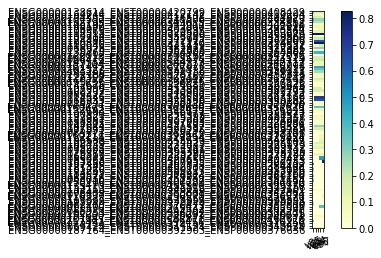

In [21]:
plt.imshow(dfLEV, cmap="YlGnBu")
plt.colorbar()
plt.xticks(range(len(dfLEV.columns)),dfLEV.columns, rotation=20)
plt.yticks(range(len(dfLEV)),dfLEV.index)
plt.show()

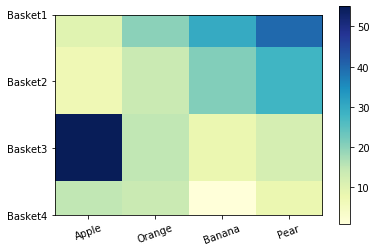

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
 # https://www.pythonprogramming.in/generate-a-heatmap-in-matplotlib-using-pandas-data.html
df = pd.DataFrame([[10, 20, 30, 40], [7, 14, 21, 28], [55, 15, 8, 12],
                    [15, 14, 1, 8]],
                  columns=['Apple', 'Orange', 'Banana', 'Pear'],
                  index=['Basket1', 'Basket2', 'Basket3', 'Basket4']
                  )
 
plt.imshow(df, cmap="YlGnBu")
plt.colorbar()
plt.xticks(range(len(df)),df.columns, rotation=20)
plt.yticks(range(len(df)),df.index)
plt.show()

In [15]:
df

,Apple,Orange,Banana,Pear
Basket1,10,20,30,40
Basket2,7,14,21,28
Basket3,55,15,8,12
Basket4,15,14,1,8


# SAVED none duplicated HGNC genes, 
### there was 1 gene symbol for 1 stableID_key versus having multimapped Stablekeys to 1 gene.
- 1 single ENSEMBL key in each release, sort by greatest distance from uniprot for final figure

saving file...
```python
countss = dyn['HGNC_gene'].value_counts()
countss = pd.DataFrame(countss)
countss.to_csv("VERSUS_UKB_shared_dynamic2_HGNC_GENE_COUNTS.csv")
```

genes none duplicated
```
MTHFD1
GNAI2
UTP4
NCF1
DDX41
AGK
SVIL
RPL11
RAPGEF6
AKAP8L
CAST
EP400
CUTA
SURF2
FHL2
FECH
RAD50

...
...

ECT2
CASK
FAM135A
DDX24
ANXA11
HAT1
DIABLO
XRCC1
TRERF1
SPTB
YAP1
ERC1
TCOF1
SOX5
NRF1
BRD2
```


---
---
---
---
---
---
---
---

## ALSO did QC for my identity score values
- confirm no hidden characters alter identity score (used python strip())- the results were unchanged after QC

- confirmed the TRUE and FALSE myidentity score results were correct, all TRUE files  have sequnce identical to my canonical sequences and all FALSE files do not have identical match 

- MISMAP data code written in 19_09_11_Ensembl_versionIDs_proteinSeq_differences_CYSLYScoordinatesTESTING

```python 
  Identical_UKB_seq  Count
0              True   5925
1             False   4347

  Identical_UKB_seq  Count
0              True   5957
1             False   4522

  Identical_UKB_seq  Count
0              True   6097
1             False   4602

  Identical_UKB_seq  Count
0              True   6127
1             False   4623

  Identical_UKB_seq  Count
0              True   6052
1             False   4598
```

## TODO- 2 scripts for QC
1. script that confirms results of TRUE FALSE comparing uniprot canonical seq in dict form to the fasta files
    - I have each fasta file, seperated into True and False
    - double check the True and False files but adding column for specific False reasons the seq does not match
    
    - added distance metrics 
        - hamming distance, allows substitutions only
        - Levenshtein distance, allows single sub, inser, del only
    
2. script that confirms results of which Uniprot IDs do not have a canonical sequence match in any of the release fasta files...total 49 canonical sequneces that SHOULD NOT BE PRESENT IN ANY RELEASES

# TODO 2  confirm these 49 IDs do not have a canonical sequence match in any of the Ensembl release fasta files

In [1]:
# FOUND THESE UNIPROT IDS have canonical sequences that are not in the fasta of ANY RELEASES!!!
# DOUBLE CHECK THAT ALL OF THESE SEQUENCES ARE NOT IN THE FASTA FILES

noSeqMatchers = ['A0FGR8',
 'A6NNF4',
 'O14965',
 'O15061',
 'O15392',
 'O43708',
 'O60645',
 'O75400',
 'P02765',
 'P07686',
 'P11182',
 'P11532',
 'P11586',
 'P16278',
 'P17927',
 'P18887',
 'P20839',
 'P30837',
 'P36639',
 'P53990',
 'Q03001',
 'Q12912',
 'Q13459',
 'Q14135',
 'Q14558',
 'Q15170',
 'Q68E01',
 'Q6PKG0',
 'Q86TG7',
 'Q8IY17',
 'Q8NBJ7',
 'Q8NBT2',
 'Q8NCA5',
 'Q8WWI1',
 'Q8WX93',
 'Q96ME1',
 'Q99729',
 'Q9BV68',
 'Q9BX63',
 'Q9BZ29',
 'Q9NRG7',
 'Q9P2N6',
 'Q9UJ41',
 'Q9UM54',
 'Q9UMY4',
 'Q9UNH6',
 'Q9UNH7',
 'Q9Y520',
 'Q9Y679']

In [2]:
len(noSeqMatchers)

49

In [6]:
enspA3KN83 = "MVEPGQDLLLAALSESGISPNDLFDIDGGDAGLATPMPTPSVQQSVPLSALELGLETEAAVPVKQEPETVPTPALLNVRQPPSTTTFVLNQINHLPPLGSTIVMTKTPPVTTNRQTITLTKFIQTTASTRPSVSAPTVRNAMTSAPSKDQVQLKDLLKNNSLNELMKLKPPANIAQPVATAATDVSNGTVKKESSNKEGARMWINDMKMRSFSPTMKVPVVKEDDEPEEEDEEEMGHAETYAEYMPIKLKIGLRHPDAVVETSSLSSVTPPDVWYKTSISEETIDNGWLSALQLEAITYAAQQHETFLPNGDRAGFLIGDGAGVGKGRTIAGIIYENYLLSRKRALWFSVSNDLKYDAERDLRDIGAKNILVHSLNKFKYGKISSKHNGSVKKGVIFATYSSLIGESQSGGKYKTRLKQLLHWCGDDFDGVIVFDECHKAKNLCPVGSSKPTKTGLAVLELQNKLPKARVVYASATGASEPRNMAYMNRLGIWGEGTPFREFSDFIQAVERRGVGAMEIVAMDMKLRGMYIARQLSFTGVTFKIEEVLLSQSYVKMYNKAVKLWVIARERFQQAADLIDAEQRMKKSMWGQFWSAHQRFFKYLCIASKVKRVVQLAREEIKNGKCVVIGLQSTGEARTLEALEEGGGELNDFVSTAKGVLQSLIEKHFPAPDRKKLYSLLGIDLTAPSNNSSPRDSPCKENKIKKRKGEEITREAKKARKVGGLTGSSSDDSGSESDASDNEESDYESSKNMSSGDDDDFNPFLDESNEDDENDPWLIRKDHKKNKEKKKKKSIDPDSIQSALLASGLGSKRPSFSSTPVISPAPNSTPANSNTNSNSSLITSQDAVERAQQMKKDLLDKLEKLAEDLPPNTLDELIDELGGPENVAEMTGRKGRVVSNDDGSISYESRSELDVPVEILNITEKQRFMDGDKNIAIISEAASSGISLQADRRAKNQRRRVHMTLELPWSADRAIQQFGRTHRSNQVTAPEYVFLISELAGEQRFASIVAKRLESLGALTHGDRRATESRDLSRFNFDNKYGRNALEIVMKSIVNLDSPMVSPPPDYPGEFFKDVRQGLIGVGLINVEDRSGILTLDKDYNNIGKFLNRILGMEVHQQNALFQYFADTLTAVVQNAKKNGRYDMGILDLGSGDEKVRKSDVKKFLTPGYSTSGHVELYTISVERGMSWEEATKIWAELTGPDDGFYLSLQIRNNKKTAILVKEVNPKKKLFLVYRPNTGKQLKLEIYADLKKKYKKVVSDDALMHWLDQYNSSADTCTHAYWRGNCKKASLGLVCEIGLRCRTYYVLCGSVLSVWTKVEGVLASVSGTNVKMQIVRLRTEDGQRIVGLIIPANCVSPLVNLLSTSDQSQQLAVQQKQLWQQHHPQSITNLSNA"

ukbA3KN83 = "MVEPGQDLLLAALSESGISPNDLFDIDGGDAGLATPMPTPSVQQSVPLSALELGLETEAAVPVKQEPETVPTPALLNVRQQPPSTTTFVLNQINHLPPLGSTIVMTKTPPVTTNRQTITLTKFIQTTASTRPSVSAPTVRNAMTSAPSKDQVQLKDLLKNNSLNELMKLKPPANIAQPVATAATDVSNGTVKKESSNKEGARMWINDMKMRSFSPTMKVPVVKEDDEPEEEDEEEMGHAETYAEYMPIKLKIGLRHPDAVVETSSLSSVTPPDVWYKTSISEETIDNGWLSALQLEAITYAAQQHETFLPNGDRAGFLIGDGAGVGKGRTIAGIIYENYLLSRKRALWFSVSNDLKYDAERDLRDIGAKNILVHSLNKFKYGKISSKHNGSVKKGVIFATYSSLIGESQSGGKYKTRLKQLLHWCGDDFDGVIVFDECHKAKNLCPVGSSKPTKTGLAVLELQNKLPKARVVYASATGASEPRNMAYMNRLGIWGEGTPFREFSDFIQAVERRGVGAMEIVAMDMKLRGMYIARQLSFTGVTFKIEEVLLSQSYVKMYNKAVKLWVIARERFQQAADLIDAEQRMKKSMWGQFWSAHQRFFKYLCIASKVKRVVQLAREEIKNGKCVVIGLQSTGEARTLEALEEGGGELNDFVSTAKGVLQSLIEKHFPAPDRKKLYSLLGIDLTAPSNNSSPRDSPCKENKIKKRKGEEITREAKKARKVGGLTGSSSDDSGSESDASDNEESDYESSKNMSSGDDDDFNPFLDESNEDDENDPWLIRKDHKKNKEKKKKKSIDPDSIQSALLASGLGSKRPSFSSTPVISPAPNSTPANSNTNSNSSLITSQDAVERAQQMKKDLLDKLEKLAEDLPPNTLDELIDELGGPENVAEMTGRKGRVVSNDDGSISYESRSELDVPVEILNITEKQRFMDGDKNIAIISEAASSGISLQADRRAKNQRRRVHMTLELPWSADRAIQQFGRTHRSNQVTAPEYVFLISELAGEQRFASIVAKRLESLGALTHGDRRATESRDLSRFNFDNKYGRNALEIVMKSIVNLDSPMVSPPPDYPGEFFKDVRQGLIGVGLINVEDRSGILTLDKDYNNIGKFLNRILGMEVHQQNALFQYFADTLTAVVQNAKKNGRYDMGILDLGSGDEKVRKSDVKKFLTPGYSTSGHVELYTISVERGMSWEEATKIWAELTGPDDGFYLSLQIRNNKKTAILVKEVNPKKKLFLVYRPNTGKQLKLEIYADLKKKYKKVVSDDALMHWLDQYNSSADTCTHAYWRGNCKKASLGLVCEIGLRCRTYYVLCGSVLSVWTKVEGVLASVSGTNVKMQIVRLRTEDGQRIVGLIIPANCVSPLVNLLSTSDQSQQLAVQQKQLWQQHHPQSITNLSNA"

# teh ensp is from v85



In [7]:
import difflib
output_list = [li for li in difflib.ndiff(enspA3KN83, ukbA3KN83) if li[0] != ' ']
output_list

['+ Q']